> **Jupyter slideshow:** This notebook can be displayed as slides. To view it as a slideshow in your browser type in the console:


> `> jupyter nbconvert Capstone_sp_1.ipynb --to slides --post serve`


> To toggle off the slideshow cell formatting, click the `CellToolbar` button, then `View --> Cell Toolbar --> None`

![deciding to play golf](./images/LendingClub-Founded-in-2007-600x331.png)

### What is Lending Club
- Lending Club is a U.S. incorporated company that matches retail lenders to retail investors, aka peer-to-peer lending.
- Utilises technology, bypassing banks, keeping costs low
- In short, the Uber and Grab version for retail Lenders and Investors.



### Problem Statement
- From investors' perspective, likely of investment default
- Retail investors have too many fields to screen through to select loans for investment. **[Link to online review.](https://wealthpilgrim.com/lending-club-reviews/)**
- Predict which lender will default? and how many loans default per lender?
- Which fields affect loan defaults?

### Limitation
- Input information submitted by applicant, verification on some information, others could not be verified
- **[Link to online review.](https://www.moneyunder30.com/lending-club-investing)**


### Dataset
**[Link to Dataset from Kaggle.](https://www.kaggle.com/wendykan/lending-club-loan-data)**

#### Backup Dataset
- Similar Credit card default, but from a simplier dataset
- **[Link to Dataset from Kaggle.](https://www.kaggle.com/wilsonf/uci-credit-carefrom-python-woe-pkg)**

In [1]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.manifold import TSNE
import joblib

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import matplotlib.patheffects as PathEffects


sns.set()


In [2]:
pd.set_option('display.width', 5000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 500)

In [3]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [4]:
start_time = time.time()

sns.set()

In [4]:
os.chdir(r'E:\GA_DSI\Projects\Capstone\lending-club-loan-data')

In [5]:
loan_full_csv = 'loan.csv'

with open(loan_full_csv, mode="r", encoding="utf8") as loan_full_raw:
    loan_full_raw = pd.read_csv(loan_full_raw)

C:\Anaconda3\envs\env_1_work\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.



In [6]:
# Show class balance for majority / minority class
print(loan_full_raw["acc_now_delinq"].value_counts(normalize=False, dropna=False))
print(loan_full_raw["acc_now_delinq"].value_counts(normalize=True, dropna=False))
#loan_sp_1_raw["acc_now_delinq"].value_counts()/loan_sp_1_clean["acc_now_delinq"].shape[0]

0.0     2251857
1.0        8293
2.0         421
3.0          50
NaN          29
4.0          11
5.0           3
6.0           2
14.0          1
7.0           1
Name: acc_now_delinq, dtype: int64
0.0     9.961025e-01
1.0     3.668385e-03
2.0     1.862281e-04
3.0     2.211736e-05
NaN     1.282807e-05
4.0     4.865818e-06
5.0     1.327041e-06
6.0     8.846943e-07
14.0    4.423471e-07
7.0     4.423471e-07
Name: acc_now_delinq, dtype: float64


In [7]:
# Func to check for null values
def check_null_counts(df):
    null_counts = df.isnull().sum()
    null_counts_largerthan0 = null_counts[null_counts > 0]
    return pd.DataFrame(data=null_counts_largerthan0, columns=["Blank Counts"])
    
def check_null_counts_per(df):
    null_counts_largerthan0_per = (check_null_counts(df)/df.shape[0])
    null_counts_largerthan0_per.sort_values(by=check_null_counts(df).columns[0], inplace=True, ascending=False)
    return null_counts_largerthan0_per
    

In [8]:
# Fuctions for visualisation
#Identify multicollinearity
def corr_heatmap(df):
    fig, ax = plt.subplots(figsize=(100,100))
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df.corr(), mask=mask, ax=ax,annot=True,center=0,cmap='coolwarm')
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12,rotation = 90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)
    plt.show()
    
#Identify correlation to target
def corr_heatmap_target(df, target="acc_now_delinq"):
    fig, ax = plt.subplots(figsize=(6, 60))
    sns.heatmap(df.corr()[[target]].sort_values([target]),
            vmax=1, vmin=-1, cmap='coolwarm', annot=True, ax=ax, linewidths=1);
    ax.invert_yaxis()
    
# Heatmap to identify high corr
def corr_heatmap_interate(df, target):
    for i in df.columns.to_list():
        corr_heatmap_target(df, i)

In [9]:
# Drop rows with target col ("acc_now_delinq") as "NA"
loan_full_raw.dropna(subset=["acc_now_delinq"], inplace=True)

In [10]:
# Change target col ("acc_now_deling"), for all >1 to 1
loan_full_raw.loc[loan_full_raw["acc_now_delinq"] >= 1, "acc_now_delinq"] = 1.0

# Show class balance for majority / minority class
print(loan_full_raw["acc_now_delinq"].value_counts(normalize=False, dropna=False))
print(loan_full_raw["acc_now_delinq"].value_counts(normalize=True, dropna=False))

0.0    2251857
1.0       8782
Name: acc_now_delinq, dtype: int64
0.0    0.996115
1.0    0.003885
Name: acc_now_delinq, dtype: float64


In [11]:
# Drop ID features, as not used in prediction
loan_full_raw.drop(['id', 'member_id'], axis=1, inplace=True)

# Drop features that do have any values
loan_full_raw.drop(['url', 'desc'], axis=1, inplace=True)

In [12]:
# Drop features that due to Hardship is Y
features_to_drop_1 = ['mths_since_last_record', 'next_pymnt_d', 'revol_bal_joint', 'sec_app_earliest_cr_line',
                    'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
                    'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
                    'sec_app_collections_12_mths_ex_med',
                    'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status',
                    'hardship_amount', 'hardship_start_date', 'hardship_end_date',
                    'payment_plan_start_date', 'hardship_dpd', 'hardship_loan_status',
                    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
                    'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status',
                    'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term'
                      ]



In [13]:
list_datetime = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]

list_high_corr = ["funded_amnt", "funded_amnt_inv", "installment", "num_sats", "out_prncp_inv", "total_pymnt_inv", "total_rec_prncp",
                  "collection_recovery_fee", "num_actv_rev_tl", "total_rev_hi_lim", "bc_util", "num_rev_accts", "total_il_high_credit_limit", 
                  "tot_hi_cred_lim", "avg_cur_bal", "num_op_rev_tl", "open_il_12m", "bc_open_to_buy", "num_actv_bc_tl", "open_rv_12m",
                  "mths_since_recent_revol_delinq"]

# List of features that has more than 70% blanks
list_high_count_blanks = ["verification_status_joint", "annual_inc_joint", "dti_joint"]

In [14]:
# Drop features that have high corr
loan_full_raw.drop(list_high_corr, axis=1, inplace=True)

In [15]:
# Drop features that on date values
loan_full_raw.drop(list_datetime, axis=1, inplace=True)

In [16]:
# Drop features that has more than 90% blanks
loan_full_raw.drop(list_high_count_blanks, axis=1, inplace=True)

In [17]:
# Drop features that have zero correlation from heatmap
loan_full_raw.drop(["policy_code", "deferral_term", "hardship_length", "title", "emp_title", "zip_code", "grade"], axis=1, inplace=True)

In [18]:
# Drop features that due to Hardship is Y
loan_full_raw.drop(columns=features_to_drop_1, axis=1, inplace=True)

In [19]:
check_null_counts(loan_full_raw).merge(check_null_counts_per(loan_full_raw), left_index=True, right_index=True)

,Blank Counts_x,Blank Counts_y
emp_length,146907,6.498472e-02
dti,1711,7.568656e-04
inq_last_6mths,1,4.423528e-07
mths_since_last_delinq,1158473,5.124538e-01
revol_util,1773,7.842915e-04
collections_12_mths_ex_med,116,5.131293e-05
mths_since_last_major_derog,1679864,7.430926e-01
tot_coll_amt,70247,3.107396e-02
tot_cur_bal,70247,3.107396e-02
open_acc_6m,866101,3.831222e-01


In [20]:
def showcats(df,features):
    for i in features:
        print('-------',i,'---------')
        print(df[i].value_counts(ascending=False, normalize = True)*100)

In [ ]:
# Start of EDA
# function for countplot

def subplot_countplot(list_of_columns, list_of_titles, list_of_ylabel, list_of_xlabel, dataframe):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 100)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.countplot(dataframe[column], color="g", alpha=0.5, ax=ax[i], orient="v") # feel free to add more settings
        ax[i].set_title(list_of_titles[i])
        ax[i].set_ylabel(list_of_ylabel[i])
        ax[i].set_xlabel(list_of_xlabel[i])
        # Set titles, labels, etc here for each subplot
    plt.show()


In [ ]:
# Need to use countplots for object type instead of histogram
# Histogram for participation rates
# Pending, cause took too long to run 
#list_of_columns_count_obj = list_dtypes_obj
#list_of_titles_count_obj = list_dtypes_obj
#list_of_ylabel_count_obj = list_dtypes_obj
#list_of_xlabel_count_obj = list_dtypes_obj

In [ ]:
def subplot_histograms(list_of_columns, list_of_titles, list_of_ylabel, list_of_xlabel, dataframe):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(25, 200)) # You'll want to specify your figsize
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(x=dataframe[column], data=dataframe, color="g", alpha=0.5, bins=51) # feel free to add more settings
        ax[i].set_title(list_of_titles[i])
        ax[i].set_ylabel(list_of_ylabel[i])
        ax[i].set_xlabel(list_of_xlabel[i])
        # Set titles, labels, etc here for each subplot
    plt.show()

In [ ]:
# Pending, cause took too long to run 
#list_of_columns_hist_num = list_dtypes_num
#list_of_titles_hist_num = list_dtypes_num
#list_of_ylabel_hist_num = list_dtypes_num
#list_of_xlabel_hist_num = list_dtypes_num

In [ ]:
def subplot_scatter(list_of_columns, list_of_rows, list_of_titles, list_of_ylabel, list_of_xlabel, dataframe):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 250)) # You'll want to specify your figsize
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, (column, row) in enumerate(zip(list_of_columns, list_of_rows)): # Gives us an index value to get into all our lists
        ax[i].scatter(dataframe[row], dataframe[column], color="g", alpha=0.5) # feel free to add more settings
        ax[i].set_title(list_of_titles[i])
        ax[i].set_ylabel(list_of_ylabel[i])
        ax[i].set_xlabel(list_of_xlabel[i])
        # Set titles, labels, etc here for each subplot
    plt.show()


In [ ]:
# Pending, cause took too long to run 
#list_of_rows_scatter = loan_sp_1_clean[list_obj_n_target].columns.tolist()
#list_of_columns_scatter = ["acc_now_delinq" for x in range(len(loan_sp_1_clean[list_obj_n_target].columns.tolist()))]
#list_of_titles_scatter = loan_sp_1_clean[list_obj_n_target].columns.tolist()
#list_of_xlabel_scatter = loan_sp_1_clean[list_obj_n_target].columns.tolist()
#list_of_ylabel_scatter = ["acc_now_delinq" for x in range(len(loan_sp_1_clean[list_obj_n_target].columns.tolist()))]
#subplot_scatter(list_of_columns_scatter, list_of_rows_scatter, list_of_titles_scatter, list_of_xlabel_scatter, list_of_ylabel_scatter, loan_sp_1_clean[list_obj_n_target])

In [ ]:
# Pairplot
# Pending, cause took too long to run 
#sns.pairplot(loan_sp_1_raw.select_dtypes(include="number"))

In [21]:
# Cleaning
# Function to fillna for selected features to 0
def fill_cols_to_0(col_1, *args, df, fill=0):
    df.loc[:, [col_1, *args]] = df[[col_1, *args]].fillna(fill)
    return df

In [ ]:
# fill_cols_to_0('annual_inc_joint', 'dti_joint')
# fill_cols_to_0('verification_status_joint', fill='NA')

In [ ]:
# # Missing 'verification_status_joint' data inpute with 'Not Verified'
# loan_sp_1_raw.loc[(loan_sp_1_raw['annual_inc_joint'].notnull()) & (loan_sp_1_raw['verification_status_joint'].isnull()),
#                   'verification_status_joint'] = 'Not Verified'

In [ ]:
# mask = ['annual_inc_joint', 'dti_joint', 'verification_status_joint']
#loan_sp_1_raw[mask]

In [22]:
# Blank cells fill to 0
fill_cols_to_0('mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'mths_since_rcnt_il', 
               "open_acc_6m", "open_act_il", "open_il_24m", "total_bal_il", "open_rv_24m", "max_bal_bc", "inq_fi",
               "total_cu_tl", "inq_last_12m", "tot_coll_amt", "tot_cur_bal", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", 
               "mo_sin_rcnt_tl", "num_accts_ever_120_pd", "num_bc_sats", "num_bc_tl", "num_il_tl", "num_rev_tl_bal_gt_0", "num_tl_30dpd", 
               "num_tl_90g_dpd_24m", "num_tl_op_past_12m", "acc_open_past_24mths", "mort_acc", "total_bal_ex_mort", "total_bc_limit", 
               df=loan_full_raw)

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_bc_sats,num_bc_tl,num_il_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,36 months,13.56,C1,10+ years,RENT,55000.0,Not Verified,Current,n,debt_consolidation,NY,18.24,0.0,1.0,0.0,9.0,1.0,4341,10.3,34.0,w,2386.02,167.020000,53.04,0.00,0.00,84.92,0.0,0.0,Individual,0.0,0.0,16901.0,2.0,2.0,2.0,2.0,12560.0,69.0,7.0,2137.0,28.0,1.0,11.0,2.0,9.0,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,3.0,16.0,5.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,16901.0,36500.0,N,Cash,N
1,30000,60 months,18.94,D2,10+ years,MORTGAGE,90000.0,Source Verified,Current,n,debt_consolidation,LA,26.52,0.0,0.0,71.0,13.0,1.0,12315,24.2,44.0,w,29387.75,1507.110000,894.86,0.00,0.00,777.23,0.0,0.0,Individual,0.0,1208.0,321915.0,4.0,4.0,3.0,3.0,87153.0,88.0,5.0,998.0,57.0,2.0,15.0,2.0,10.0,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,0.0,4.0,0.0,4.0,9.0,27.0,4.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,99468.0,15000.0,N,Cash,N
2,5000,36 months,17.97,D1,6 years,MORTGAGE,59280.0,Source Verified,Current,n,debt_consolidation,MI,10.51,0.0,0.0,0.0,8.0,0.0,4599,19.1,13.0,w,4787.21,353.890000,141.10,0.00,0.00,180.69,0.0,0.0,Individual,0.0,0.0,110299.0,0.0,1.0,2.0,14.0,7150.0,72.0,2.0,0.0,35.0,1.0,5.0,0.0,4.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,0.0,14.0,0.0,3.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,11749.0,13800.0,N,Cash,N
3,4000,36 months,18.94,D2,10+ years,MORTGAGE,92000.0,Source Verified,Current,n,debt_consolidation,WA,16.74,0.0,0.0,0.0,10.0,0.0,5468,78.1,13.0,w,3831.93,286.710000,118.64,0.00,0.00,146.51,0.0,0.0,Individual,0.0,686.0,305049.0,1.0,5.0,5.0,5.0,30683.0,68.0,0.0,3761.0,70.0,2.0,4.0,3.0,5.0,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0,0.0,5.0,0.0,1.0,2.0,7.0,2.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,36151.0,5000.0,N,Cash,N
4,30000,60 months,16.14,C4,10+ years,MORTGAGE,57250.0,Not Verified,Current,n,debt_consolidation,MD,26.35,0.0,0.0,0.0,12.0,0.0,829,3.6,26.0,w,29339.02,1423.210000,762.23,0.00,0.00,731.78,0.0,0.0,Individual,0.0,0.0,116007.0,3.0,5.0,5.0,4.0,28845.0,89.0,4.0,516.0,54.0,1.0,0.0,0.0,9.0,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0,0.0,13.0,0.0,3.0,8.0,9.0,2.0,0.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,29674.0,9300.0,N,Cash,N
5,5550,36 months,15.02,C3,10+ years,MORTGAGE,152500.0,Not Verified,Current,n,credit_card,IN,37.94,0.0,3.0,0.0,18.0,0.0,53854,48.1,44.0,w,5302.50,377.950000,130.45,0.00,0.00,192.45,0.0,0.0,Individual,0.0,0.0,685749.0,1.0,7.0,3.0,4.0,131524.0,72.0,4.0,17584.0,58.0,2.0,4.0,6.0,8.0,0.0,0.0,195.0,176.0,10.0,4.0,6.0,20.0,0.0,3.0,0.0,6.0,10.0,23.0,7.0,0.0,0.0,0.0,4.0,100.0,60.0,0.0,0.0,185378.0,65900.0,N,Cash,N
6,2000,36 months,17.97,D1,4 years,RENT,51000.0,Source Verified,Current,n,debt_consolidation,IL,2.40,0.0,1.0,0.0,1.0,0.0,0,NaN,9.0,w,1914.71,141.560000,56.27,0.00,0.00,72.28,0.0,0.0,Individual,0.0,0.0,854.0,0.0,0.0,3.0,7.0,0.0,NaN,1.0,0.0,100.0,0.0,0.0,1.0,4.0,0.0,0.0,169.0,40.0,23.0,7.0,0.0,NaN,0.0,1.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,2.0,100.0,NaN,0.0,0.0,854.0,0.0,N,Cash,N
7,6000,36 months,13.56,C1,10+ years,RENT,65000.0,Source Verified,Current,n,credit_car

In [23]:
check_null_counts(loan_full_raw).merge(check_null_counts_per(loan_full_raw), left_index=True, right_index=True)

,Blank Counts_x,Blank Counts_y
emp_length,146907,6.498472e-02
dti,1711,7.568656e-04
inq_last_6mths,1,4.423528e-07
revol_util,1773,7.842915e-04
collections_12_mths_ex_med,116,5.131293e-05
il_util,1068821,4.727960e-01
all_util,866319,3.832186e-01
chargeoff_within_12_mths,116,5.131293e-05
mo_sin_old_il_acct,139042,6.150562e-02
mths_since_recent_bc,73383,3.246118e-02


In [24]:
list_int_null = check_null_counts(loan_full_raw).index.to_list()

In [25]:
list_int_null.remove('emp_length')
list_int_null

['dti',
 'inq_last_6mths',
 'revol_util',
 'collections_12_mths_ex_med',
 'il_util',
 'all_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_tl_120dpd_2m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens']

In [27]:
# Split features into "Object" and "Number" dtypes
list_dtypes_obj = loan_full_raw.select_dtypes(include="object").columns.tolist()
list_dtypes_num = loan_full_raw.select_dtypes(include="number").columns.tolist()
list_all_features = loan_full_raw.columns.tolist()

In [44]:
check_null_counts(loan_full_raw[list_dtypes_obj])

,Blank Counts
emp_length,146907


In [47]:
loan_cat_not_imp = loan_full_raw[list_dtypes_obj]

In [49]:
loan_cat_not_imp.drop(columns='emp_length', axis=1, inplace=True)

C:\Anaconda3\envs\env_1_work\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [50]:
loan_cat_not_imp.columns

Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag'], dtype='object')

In [31]:
#  Simple Impute taking too long to running on full dataset
#imp_sp = SimpleImputer(missing_values=np.nan, strategy="most_frequent", verbose=2)

In [ ]:
#  Simple Impute taking too long to running on full dataset 
#loan_full_imputed_sp = imp_sp.fit_transform(loan_full_raw[list_dtypes_obj])

In [ ]:
#joblib.dump(imp_sp, "imp_sp_full.pkl")

In [ ]:
#  Unhash when needed
#  Load the model from the file 
#imp_sp_from_joblib = joblib.load('imp_sp_full.pkl')  

#  Unhash when needed
#  Use the loaded model to make predictions 
#loan_sp_full_imputed_sp = imp_sp_from_joblib.transform(loan_sp_full_raw[list_dtypes_obj]) 

In [ ]:
#df = df.fillna(df.mode().iloc[0])

In [ ]:
#loan_full_imputed_sp = loan_full_raw[list_dtypes_obj].fillna(loan_full_raw[list_dtypes_obj].mode())

In [36]:
loan_full_raw['emp_length'].mode()[0]

'10+ years'

In [43]:
# one method to replace SimpleImputer as its taking way too long
loan_sp_imp_emplength = loan_full_raw['emp_length'].fillna(loan_full_raw['emp_length'].mode()[0])

In [58]:
# Merge numerical and object dtypes features
loan_full_imputed_sp_df = pd.merge(loan_cat_not_imp, loan_sp_imp_emplength, right_index=True, left_index=True)

In [59]:
loan_full_imputed_sp_df.columns

Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'emp_length'], dtype='object')

In [60]:
check_null_counts(loan_full_imputed_sp_df)

,Blank Counts


In [37]:
br_estimator = BayesianRidge()
#et_estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)

# Impute missing values using Multivariate feature imputation
imp_br = IterativeImputer(estimator=br_estimator, max_iter=10, random_state=5, sample_posterior=True, min_value=0, verbose=2, 
                          initial_strategy="most_frequent")
#imp_et = IterativeImputer(estimator=et_estimator, max_iter=10, random_state=5, sample_posterior=False, min_value=0, verbose=2)

In [38]:
loan_full_imputed_br = imp_br.fit_transform(loan_full_raw[list_dtypes_num])
#loan_sp_1_imputed_et = imp_et.fit_transform(loan_sp_1_raw[num_features])


[IterativeImputer] Completing matrix with shape (2260639, 61)
[IterativeImputer] Ending imputation round 1/10, elapsed time 483.74
[IterativeImputer] Ending imputation round 2/10, elapsed time 738.34
[IterativeImputer] Ending imputation round 3/10, elapsed time 986.87
[IterativeImputer] Ending imputation round 4/10, elapsed time 1242.98
[IterativeImputer] Ending imputation round 5/10, elapsed time 1526.76
[IterativeImputer] Ending imputation round 6/10, elapsed time 1880.07
[IterativeImputer] Ending imputation round 7/10, elapsed time 2134.51
[IterativeImputer] Ending imputation round 8/10, elapsed time 2518.94
[IterativeImputer] Ending imputation round 9/10, elapsed time 2770.11
[IterativeImputer] Ending imputation round 10/10, elapsed time 3016.71


In [39]:
joblib.dump(imp_br, "imp_br_full.pkl")

['imp_br_full.pkl']

In [34]:
#  Unhash when needed
#  Load the model from the file 
#imp_br_from_joblib = joblib.load('imp_br_full.pkl')  

#  Unhash when needed
#  Use the loaded model to make predictions 
#loan_full_imputed_br = imp_br_from_joblib.transform(loan_full_raw[list_dtypes_num]) 

[IterativeImputer] Completing matrix with shape (226062, 61)
[IterativeImputer] Ending imputation round 1/10, elapsed time 3.79
[IterativeImputer] Ending imputation round 2/10, elapsed time 6.99
[IterativeImputer] Ending imputation round 3/10, elapsed time 10.20
[IterativeImputer] Ending imputation round 4/10, elapsed time 13.36
[IterativeImputer] Ending imputation round 5/10, elapsed time 16.55
[IterativeImputer] Ending imputation round 6/10, elapsed time 19.82
[IterativeImputer] Ending imputation round 7/10, elapsed time 23.01
[IterativeImputer] Ending imputation round 8/10, elapsed time 26.16
[IterativeImputer] Ending imputation round 9/10, elapsed time 29.62
[IterativeImputer] Ending imputation round 10/10, elapsed time 32.74


In [54]:
loan_full_imputed_br_df = pd.DataFrame(data=loan_full_imputed_br, columns=list_dtypes_num)
#loan_sp_1_imputed_et_df = pd.DataFrame(data=loan_sp_1_imputed_et, columns=num_features)

In [43]:
#loan_sp_3_imputed_sp_df = pd.DataFrame(data=loan_sp_3_imputed_sp, columns=list_dtypes_obj)

In [56]:
check_null_counts(loan_full_imputed_br_df)

,Blank Counts


In [61]:
# Merge numerical and object dtypes features
loan_full_clean = pd.merge(loan_full_imputed_br_df, loan_full_imputed_sp_df, right_index=True, left_index=True)
loan_full_clean = loan_full_clean[list_all_features]

In [62]:
list_dtypes_obj_clean = loan_full_clean.select_dtypes(include="object").columns.tolist()

In [63]:
loan_full_clean_dum = pd.get_dummies(loan_full_clean, drop_first=True, columns=list_dtypes_obj_clean)

In [64]:
loan_full_clean_dum.head(10)

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_bc_sats,num_bc_tl,num_il_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App,hardship_flag_Y,disbursement_method_DirectPay,debt_settlement_flag_Y
0,2500.0,13.56,55000.0,18.24,0.0,1.0,0.0,9.0,1.0,4341.0,10.300000,34.0,2386.02,167.02,53.04,0.0,0.0,84.92,0.0,0.0,0.0,0.0,16901.0,2.0,2.0,2.0,2.0,12560.0,69.000000,7.0,2137.0,28.0,1.0,11.0,2.0,9.0,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.000000,0.0,2.0,0.0,3.0,3.0,16.0,5.0,0.0,0.0,0.0,3.0,100.0,0.00000,1.0,0.0,16901.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,30000.0,18.94,90000.0,26.52,0.0,0.0,71.0,13.0,1.0,12315.0,24.200000,44.0,29387.75,1507.11,894.86,0.0,0.0,777.23,0.0,0.0,0.0,1208.0,321915.0,4.0,4.0,3.0,3.0,87153.0,88.000000,5.0,998.0,57.0,2.0,15.0,2.0,10.0,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.000000,0.0,4.0,0.0,4.0,9.0,27.0,4.0,0.0,0.0,0.0,6.0,95.0,0.00000,1.0,0.0,99468.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5000.0,17.97,59280.0,10.51,0.0,0.0,0.0,8.0,0.0,4599.0,19.100000,13.0,4787.21,353.89,141.10,0.0,0.0,180.69,0.0,0.0,0.0,0.0,110299.0,0.0,1.0,2.0,14.0,7150.0,72.000000,2.0,0.0,35.0,1.0,5.0,0.0,4.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.000000,0.0,14.0,0.0,3.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,100.0,0.00000,0.0,0.0,11749.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4000.0,18.94,92000.0,16.74,0.0,0.0,0.0,10.0,0.0,5468.0,78.100000,13.0,3831.93,286.71,118.64,0.0,0.0,146.51,0.0,0.0,0.0,686.0,305049.0,1.0,5.0,5.0,5.0,30683.0,68.000000,0.0,3761.0,70.0,2.0,4.0,3.0,5.0,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.000000,0.0,5.0,0.0,1.0,2.0,7.0,2.0,0.0,0.0,0.0,3.0,100.0,100.00000,0.0,0.0,36151.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,30000.0,16.14,57250.0,26.35,0.0,0.0,0.0,12.0,0.0,829.0,3.600000,26.0,29339.02,1423.21,762.23,0.0,0.0,731.78,0.0,0.0,0.0,0.0,116007.0,3.0,5.0,5.0,4.0,28845.0,89.000000,4.0,516.0,54.0,1.0,0.0,0.0,9.0,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.000000,0.0,13.0,0.0,3.0,8.0,9.0,2.0,0.0,0.0,0.0,5.0,92.3,0.00000,0.0,0.0,29674.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

In [65]:
# Show class balance for majority / minority class
print(loan_full_clean["acc_now_delinq"].value_counts(normalize=False, dropna=False))
print(loan_full_clean["acc_now_delinq"].value_counts(normalize=True, dropna=False))
#loan_sp_1_raw["acc_now_delinq"].value_counts()/loan_sp_1_clean["acc_now_delinq"].shape[0]

0.0    2251828
1.0       8782
Name: acc_now_delinq, dtype: int64
0.0    0.996115
1.0    0.003885
Name: acc_now_delinq, dtype: float64


In [66]:
showcats(loan_full_imputed_sp_df, loan_full_imputed_sp_df.columns)

------- term ---------
 36 months    71.206637
 60 months    28.793363
Name: term, dtype: float64
------- sub_grade ---------
C1    6.453972
B5    6.205591
B4    6.183650
B3    5.817426
C2    5.799953
C3    5.714844
C4    5.622835
B2    5.601027
B1    5.544494
C5    5.163407
A5    4.760380
A4    4.240969
A1    3.839136
D1    3.617871
A3    3.237138
D2    3.224708
A2    3.076962
D3    2.867242
D4    2.516811
D5    2.124311
E1    1.485111
E2    1.323697
E3    1.181392
E4    1.006928
E5    1.002858
F1    0.593328
F2    0.411609
F3    0.344637
F4    0.270897
F5    0.228564
G1    0.181630
G2    0.118904
G3    0.092629
G4    0.075731
G5    0.069361
Name: sub_grade, dtype: float64
------- home_ownership ---------
MORTGAGE    49.164993
RENT        39.586683
OWN         11.194003
ANY          0.044058
OTHER        0.008051
NONE         0.002212
Name: home_ownership, dtype: float64
------- verification_status ---------
Source Verified    39.202677
Not Verified       32.945419
Verified           

In [ ]:
#corr_heatmap_target(loan_sp_1_clean_dum)

In [ ]:
#corr_heatmap(loan_sp_1_clean_dum)

Text(0.5, 1.0, 'num_tl_30dpd vs Target: acc_now_deling')

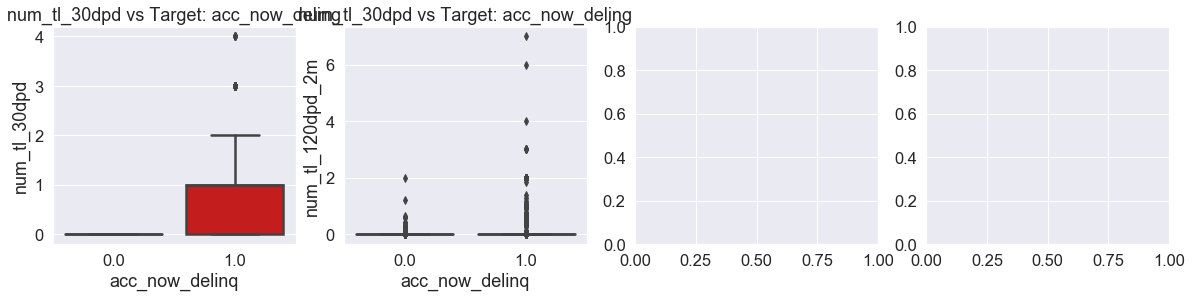

In [67]:
# Boxplot
# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ["#0101DF", "#DF0101"]
sns.boxplot(x="acc_now_delinq", y="num_tl_30dpd", data=loan_full_clean_dum, palette=colors, ax=axes[0])
axes[0].set_title('num_tl_30dpd vs Target: acc_now_deling')

colors = ["#0101DF", "#DF0101"]
sns.boxplot(x="acc_now_delinq", y="num_tl_120dpd_2m", data=loan_full_clean_dum, palette=colors, ax=axes[1])
axes[1].set_title('num_tl_30dpd vs Target: acc_now_deling')

In [68]:
loan_full_clean_dum[list_int_null].describe().T

,count,mean,std,min,25%,50%,75%,max
dti,2260610.0,18.825976,14.181887,-1.0,11.90000,17.840000,24.500000,999.000000
inq_last_6mths,2260610.0,0.576813,0.885781,0.0,0.00000,0.000000,1.000000,33.000000
revol_util,2260610.0,50.345222,24.712968,0.0,31.50000,50.300000,69.400000,892.300000
collections_12_mths_ex_med,2260610.0,0.018150,0.150813,0.0,0.00000,0.000000,0.000000,20.000000
il_util,2260610.0,64.377802,23.167742,0.0,49.00000,65.596062,81.000000,1000.000000
all_util,2260610.0,54.281189,20.337764,0.0,40.20271,55.000000,68.449871,484.494134
chargeoff_within_12_mths,2260610.0,0.008467,0.104809,0.0,0.00000,0.000000,0.000000,10.000000
mo_sin_old_il_acct,2260610.0,123.758029,53.487662,0.0,92.00000,128.000000,152.999975,999.000000
mths_since_recent_bc,2260610.0,25.364081,32.343465,0.0,6.00000,14.000000,31.000000,661.000000
mths_since_recent_inq,2260610.0,7.480471,5.958582,0.0,2.00000,6.000000,11.090421,42.886996


In [69]:
loan_full_clean_dum[list_int_null]

,dti,inq_last_6mths,revol_util,collections_12_mths_ex_med,il_util,all_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mths_since_recent_bc,mths_since_recent_inq,num_tl_120dpd_2m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens
0,18.240000,1.0,10.300000,0.0,69.000000,28.0,0.0,140.000000,1.000000,2.000000,0.000000,100.0,0.000000,1.0,0.0
1,26.520000,0.0,24.200000,0.0,88.000000,57.0,0.0,163.000000,4.000000,4.000000,0.000000,95.0,0.000000,1.0,0.0
2,10.510000,0.0,19.100000,0.0,72.000000,35.0,0.0,87.000000,77.000000,14.000000,0.000000,100.0,0.000000,0.0,0.0
3,16.740000,0.0,78.100000,0.0,68.000000,70.0,0.0,62.000000,64.000000,5.000000,0.000000,100.0,100.000000,0.0,0.0
4,26.350000,0.0,3.600000,0.0,89.000000,54.0,0.0,53.000000,2.000000,13.000000,0.000000,92.3,0.000000,0.0,0.0
5,37.940000,3.0,48.100000,0.0,72.000000,58.0,0.0,195.000000,20.000000,3.000000,0.000000,100.0,60.000000,0.0,0.0
6,2.400000,1.0,87.240323,0.0,115.492823,100.0,0.0,169.000000,39.317632,1.000000,0.000000,100.0,47.726760,0.0,0.0
7,30.100000,0.0,69.300000,0.0,87.000000,74.0,0.0,169.000000,14.000000,13.000000,0.000000,100.0,85.700000,0.0,0.0
8,21.160000,1.0,35.200000,0.0,98.000000,73.0,0.0,145.000000,6.000000,2.000000,0.000000,78.9,60.000000,0.0,0.0
9,17.430000,1.0,49.800000,0.0,45.000000,48.0,0.0,166.000000,4.000000,4.000000,0.000000,100.0,26.300000,0.0,0.0


In [70]:
loan_full_raw[list_int_null]

,dti,inq_last_6mths,revol_util,collections_12_mths_ex_med,il_util,all_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mths_since_recent_bc,mths_since_recent_inq,num_tl_120dpd_2m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens
0,18.24,1.0,10.3,0.0,69.0,28.0,0.0,140.0,1.0,2.0,0.0,100.0,0.0,1.0,0.0
1,26.52,0.0,24.2,0.0,88.0,57.0,0.0,163.0,4.0,4.0,0.0,95.0,0.0,1.0,0.0
2,10.51,0.0,19.1,0.0,72.0,35.0,0.0,87.0,77.0,14.0,0.0,100.0,0.0,0.0,0.0
3,16.74,0.0,78.1,0.0,68.0,70.0,0.0,62.0,64.0,5.0,0.0,100.0,100.0,0.0,0.0
4,26.35,0.0,3.6,0.0,89.0,54.0,0.0,53.0,2.0,13.0,0.0,92.3,0.0,0.0,0.0
5,37.94,3.0,48.1,0.0,72.0,58.0,0.0,195.0,20.0,3.0,0.0,100.0,60.0,0.0,0.0
6,2.40,1.0,NaN,0.0,NaN,100.0,0.0,169.0,NaN,1.0,0.0,100.0,NaN,0.0,0.0
7,30.10,0.0,69.3,0.0,87.0,74.0,0.0,169.0,14.0,13.0,0.0,100.0,85.7,0.0,0.0
8,21.16,1.0,35.2,0.0,98.0,73.0,0.0,145.0,6.0,2.0,0.0,78.9,60.0,0.0,0.0
9,17.43,1.0,49.8,0.0,45.0,48.0,0.0,166.0,4.0,4.0,0.0,100.0,26.3,0.0,0.0


In [72]:
# T-SNE 
tsne_2d = TSNE(n_components=2, random_state=0, verbose=1)
tsne_3d = TSNE(n_components=3, random_state=0, verbose=1)


In [42]:
# Set X & y
X = loan_sp_1_clean_dum.drop(columns=["acc_now_delinq"])
y = loan_sp_1_clean_dum["acc_now_delinq"]

In [74]:
X_2d = tsne_2d.fit_transform(X)

NameError: name 'tsne' is not defined

In [ ]:
joblib.dump(X_2d, "tsne_2d.pkl")

In [39]:
#  Unhash when needed
#  Load the model from the file 
X_2d = joblib.load('tsne_2d.pkl')  

#  Unhash when needed
#  Use the loaded model to make predictions 
#loan_sp_1_imputed_br = imp_br_from_joblib.transform(loan_sp_1_raw[list_dtypes_num]) 

[IterativeImputer] Completing matrix with shape (226062, 61)
[IterativeImputer] Ending imputation round 1/10, elapsed time 2.90
[IterativeImputer] Ending imputation round 2/10, elapsed time 5.79
[IterativeImputer] Ending imputation round 3/10, elapsed time 8.77
[IterativeImputer] Ending imputation round 4/10, elapsed time 11.69
[IterativeImputer] Ending imputation round 5/10, elapsed time 14.62
[IterativeImputer] Ending imputation round 6/10, elapsed time 17.52
[IterativeImputer] Ending imputation round 7/10, elapsed time 20.49
[IterativeImputer] Ending imputation round 8/10, elapsed time 23.41
[IterativeImputer] Ending imputation round 9/10, elapsed time 26.46
[IterativeImputer] Ending imputation round 10/10, elapsed time 29.57


In [40]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(0.104160644, 0.3366575, '0'), Text(7.6538744, -2.8836298, '1')])

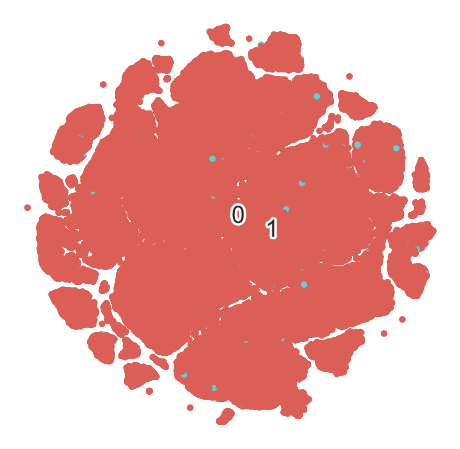

In [43]:
fashion_scatter(X_2d, y)

In [ ]:
X_3d = tsne_3d.fit_transform(X)

In [ ]:
joblib.dump(X_3d, "tsne_3d.pkl")

In [54]:
X_3d

array([ 7.4598603,  5.2696104, -4.4771447], dtype=float32)

In [3]:
#  Unhash when needed
#  Load the model from the file 
X_3d = joblib.load('tsne_3d.pkl')  

#  Unhash when needed
#  Use the loaded model to make predictions 
#loan_sp_1_imputed_br = imp_br_from_joblib.transform(loan_sp_1_raw[list_dtypes_num]) 

array([  2.6665454,   0.2325886,  -1.3940606, ..., -17.910227 ,
         1.680356 ,  -2.0858479], dtype=float32)

In [45]:
trace1 = go.Scatter3d(
    x=X_3d[:,0],
    y=X_3d[:,1],
    z=X_3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = loan_sp_1_clean_dum["acc_now_delinq"].values,
        #colorscale = 'Portland',
        #colorbar = dict(title = 'duplicate'),
        #line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='Text Similarity')
fig=dict(data=data, layout=layout)
py.plot(fig, filename='3DBubble')
#py.iplot(fig, filename='3DBubble')

C:\Anaconda3\envs\env_1_work\lib\site-packages\plotly\offline\offline.py:526: UserWarning:

Your filename `3DBubble` didn't end with .html. Adding .html to the end of your file.



'3DBubble.html'

In [71]:
loan_full_clean_dum.to_csv('./loan_full_clean.csv')

In [ ]:
# OVR - One vs Rest. Check when .fit if handle OVR

In [ ]:
# RFE
# t-SNE
# Class balance: smote?
# PCA

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))